# 5a_Total biomass (TBM) or land productivity (LP) at crop harvest 

## 1 Import the module

In [1]:
import os
import glob
import numpy as np
from osgeo import gdal
import osr
from matplotlib import pyplot as plt

## 2 Get the list of all the seasonal NPP raster data

In [2]:
dir_proj = os.getcwd()  
dir_data = "Data"

input_folder = os.path.join(dir_proj, dir_data, "4bL2_NPP_season") 
input_fhs=glob.glob(input_folder+'\*.tif')
input_fhs

['E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2009-01-01_to_2009-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2010-01-01_to_2010-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2011-01-01_to_2011-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2012-01-01_to_2012-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2013-01-01_to_2013-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2014-01-01_to_2014-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2015-01-01_to_2015-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4bL2_NPP_season\\NPP_2016-01-01_to_2016-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\X

## 3 Specify the directry of the output folder 

In [3]:
dir_proj = os.getcwd()  
dir_data = "Data"
output_folder = os.path.join(dir_proj, dir_data, "5aL2_TBP_atHarvest") 
output_folder

'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\5aL2_TBP_atHarvest'

In [4]:
# if the directory and folder does not exit, make one
if not os.path.exists(output_folder):
    os.makedirs(output_folder) 

## 4 Calculate the total biomass from the NPP

*** land productivity in ton/ha/season***

***Land productivity*** is the ***total fresh biomass production*** per season. It is derived from the NPP aggregated over crop season.

    E.g. the NPP per season = V [gC/m²/season] 
    
                  = V*22.222 [kgDM/ha/season], b/s 1 gC/m²/day (NPP) = 22.222 kgDM/ha/day (DMP)
                        
                  = V*22.222/1000 [tonDM/ha/season], b/s 1ton=1000kg
                        
***Fresh biomass production = DMP/(1-moistureContent), for C3 crops***

                         = V*22.222/1000[ton fresh/ha/season]/(1-moistureContent[-])
                        
***Fresh biomass production = 1*DMP/(1-moistureContent), for C4 crops such as sugarcane***

                         = 1.8*V*22.222/1000[ton fresh/ha/season]/(1-moistureContent[-])

C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less


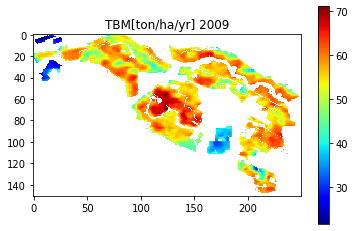

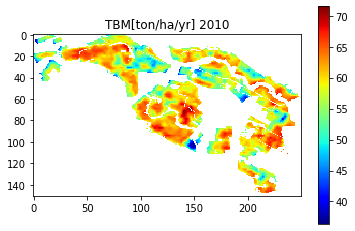

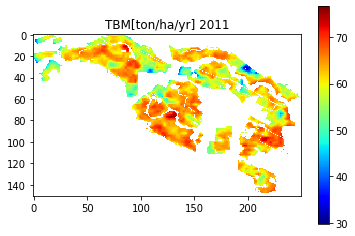

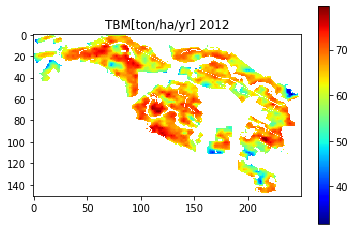

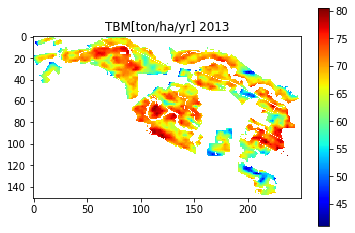

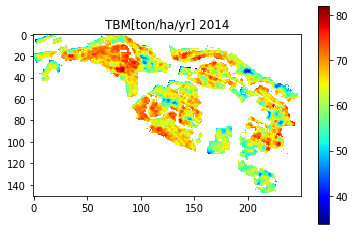

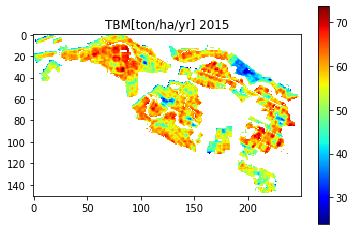

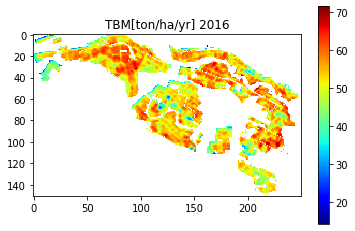

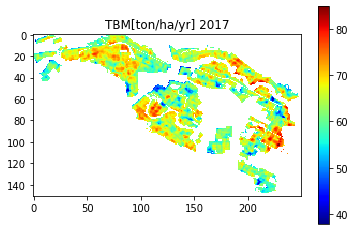

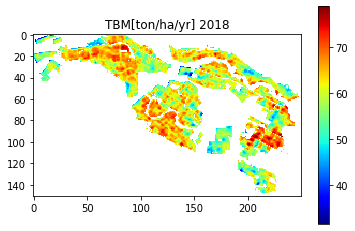

In [5]:
# Get GeoInfo: the dataset code and the time range 
def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhs[0]
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)

def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV =- 9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

## Calculate the total biomass from the NPP
## Conversion factor(CF) (1.8 for C4 crop and 1 for c crop); moisture content(MC) in the fresh product
CV = 1.8  # conversion factor for C3 crop is 1.
MC = 0.3
HI = 1

in_fh = input_fhs[0]
for in_fh in input_fhs:
    NPP = OpenRasterAsArray(in_fh)  
    NPP = np.where(NPP<0,0,NPP) #mask out flagged value -9998
    Biomass = (CV*HI*NPP*22.222/1000)/(1-MC) 

    #Compare the NPP and Biomass values
    #print (NPP)
    #print (Biomass)
       
    # save the biomassvalues in raster (tif) file format, name it with the raster_id and sowing and harvesting date
    raster_id1=os.path.split(in_fh)[-1].split('.')[-2]  # yields NPP_2009-01-01_to_2009-12-31 (the directory upto the folder and .tif are left-out)
    raster_id2=raster_id1.split('_')[1]                 # yields 2009-01-01  
    raster_id3=raster_id1.split('_')[3]                 # yields 2009-12-31 
    #print (raster_id2,raster_id3)
     
    out_fh=os.path.join(output_folder,'TBM_'+raster_id2+'_to_'+raster_id3+'.tif') 
    SaveArrayAsRaster(Biomass,out_fh,NDV,xsize,ysize,GeoT,Projection,driver) ### Save the array 'Sums' as raster
    #print(out_fh)   # print the directory of the saved file
    
    # Plot the raster map
    plt.imshow(Biomass, cmap='jet') # RdYlGn, cubehelix
    plt.colorbar()  
    plt.title ('TBM[ton/ha/yr] '+raster_id2.split('-')[0])
    plt.clim()
    plt.show()  

In [6]:
# plot the results
# plt.scatter(projection[:, 0], projection[:, 1], lw=0.1,
#           c=digits.target, cmap=plt.cm.get_cmap('cubehelix', 6))
#plt.colorbar(ticks=range(6), label='digit value')
#plt.clim(-0.5, 5.5)

## Excerice (5a) 
Calculate the TBM at harvest for your project area 



# 5b_Water productivity (WP) at crop harvest 
***Wapter productivity is the ratio of total fresh biomass production [ton/ha/season] to AETI [mm/season]***
...1 ton/ha/mm= 100 kg/m3


## 5bI Get the list of all the seasonal AETI and TBM raster data

In [7]:
dir_proj = os.getcwd()  
dir_data = "Data"

input_folder1 = os.path.join(dir_proj, dir_data, "4aL2_AETI_season") 
input_fhs1    = glob.glob(input_folder1+'\*.tif')

input_folder2 = os.path.join(dir_proj, dir_data, "5aL2_TBP_atHarvest") 
input_fhs2    = glob.glob(input_folder2+'\*.tif')

input_fhs1[0], input_fhs2[0]

('E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\4aL2_AETI_season\\AETI_2009-01-01_to_2009-12-31.tif',
 'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\5aL2_TBP_atHarvest\\TBM_2009-01-01_to_2009-12-31.tif')

## 5bII Specify the directry of the output folder 

In [8]:
dir_proj = os.getcwd()  
dir_data = "Data"

output_folder = os.path.join(dir_proj, dir_data, "5bL2_WP_atHarvest") 
output_folder

'E:\\Projects\\WaterPiP\\CaseStudies\\Xinavane\\WaPORDocker\\Data\\5bL2_WP_atHarvest'

In [9]:
# if the directory and folder does not exit, make one
if not os.path.exists(output_folder):
    os.makedirs(output_folder) 

## 5bIII Calculate the water productivity and save the raster map in the output_folder

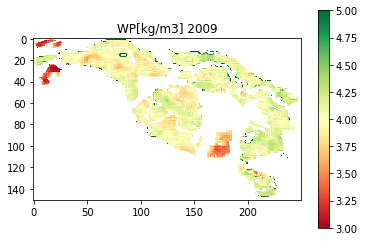

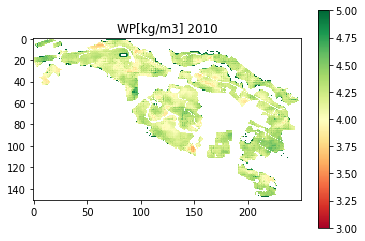

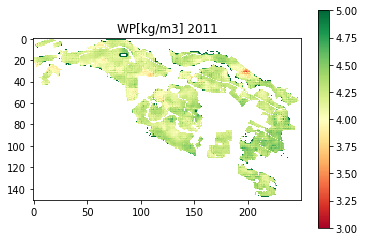

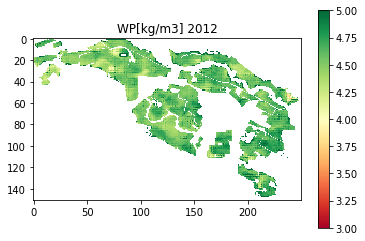

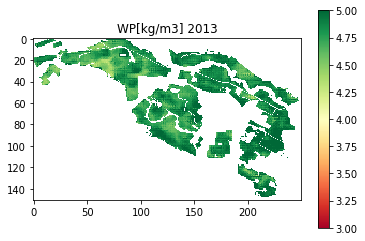

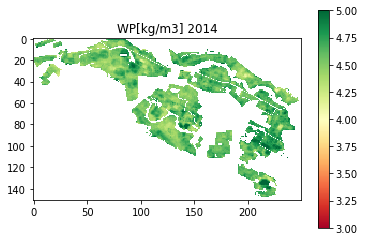

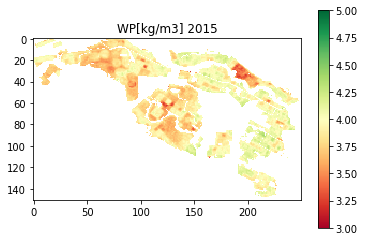

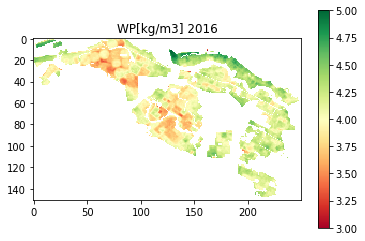

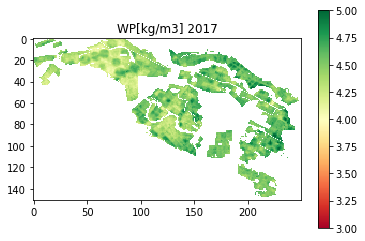

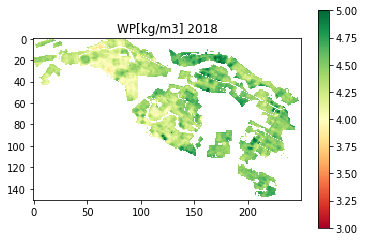

In [10]:
# Get GeoInfo: the dataset code and the time range 
def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhs[0]
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)


def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV =- 9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

## 3 Calculate the WP

AETIs = []
TBMs = []
WPs  = []
i = 0
for in_fh in input_fhs1:
    AETIi = OpenRasterAsArray(input_fhs1[i]) 
    AETIs.append(AETIi)
    TBm = OpenRasterAsArray(input_fhs2[i])
    TBMs.append(TBm)
    WPi = TBm/AETIi*100
    WPs.append(WPi)
    i+=1
    
    ## check if the correct raster fieles are used in the calaculation
    #print (input_fhs1[i])
    #print (input_fhs2[i]) 
        
    # save the biomassvalues in raster (tif) file format, name it with the raster_id and sowing and harvesting date
    raster_id1=os.path.split(in_fh)[-1].split('.')[-2]  # yields NPP_2009-01-01_to_2009-12-31 (the directory upto the folder and .tif are left-out)
    raster_id2=raster_id1.split('_')[1]                 # yields 2009-01-01  
    raster_id3=raster_id1.split('_')[3]                 # yields 2009-12-31 
    #print (raster_id2,raster_id3)
    
    out_fh=os.path.join(output_folder,'WP_'+raster_id2+'_to_'+raster_id3+'.tif')
    SaveArrayAsRaster(WPi,out_fh,NDV,xsize,ysize,GeoT,Projection,driver) ### Save the array 'Sums' as raster
    #print(out_fh)   # print the directory of the saved file
    
    # Plot the raster map
    plt.imshow(WPi, cmap='RdYlGn') #cmap=plt.cm.get_cmap('jet', 6)
    plt.colorbar()
    plt.title ('WP[kg/m3] '+raster_id2.split('-')[0])
    plt.clim(3,5)               # plt.clim(-0.5,5.5)
    plt.show()  

In [23]:
# WPs.flatten()
WPi.flatten()

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

## 5bIV Calculate the histogram of AETI, TBM and WP!? and save the raster map in the output_folder

TypeError: inner() got multiple values for argument 'ax'

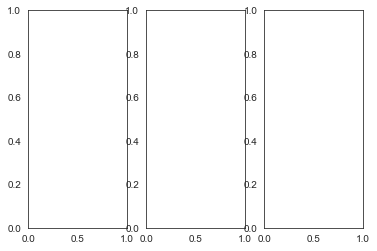

In [102]:
# import
import matplotlib.pyplot as plt

# Get GeoInfo: the dataset code and the time range 
def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhs[0]
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)


def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV =- 9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

## 3 Import 
import seaborn as sns
sns.set_style("white")

dir_proj = os.getcwd()  
dir_data = "Data"

input_folder3 = os.path.join(dir_proj, dir_data, "5bL2_WP_atHarvest") 
input_fhs3    = glob.glob(input_folder3+'\*.tif')

AETIs = []
TBMs = []
WPs  = []
i = 0
for in_fh in input_fhs1:
    AETIi = OpenRasterAsArray(input_fhs1[i]) 
    AETIi = AETIi.flatten()
    AETIs.append(AETIi)
    TBm = OpenRasterAsArray(input_fhs2[i])
    TBm=TBm.flatten()
    TBMs.append(TBm)
    WPi = OpenRasterAsArray(input_fhs3[i])
    WPi=WPi.flatten()
    WPs.append(WPi)
    
    i+=1
        

# data = data[~np.isnan(data)] removing NaN
# x = [row for row in y if not np.isnan(row).any()]

# AETIs = [row for row in AETIs if not np.isnan(row).any()] 
# TBMs = [row for row in TBMs if not np.isnan(row).any()] 
# WPs = [row for row in WPs if not np.isnan(row).any()] 

# plot
# fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
# sns.distplot(AETIs , color="dodgerblue", ax=axes[0], axlabel='Ideal')
# sns.distplot(TBMs , color="deeppink", ax=axes[1], axlabel='Fair')
# sns.distplot(WPs , color="gold", ax=axes[2], axlabel='Good')

fig, axes = plt.subplots(1,3)
plt.hist(AETIs,color="dodgerblue", ax=axes[0], axlabel='Ideal')
plt.hist(TBMs, color="deeppink", ax=axes[1], axlabel='Fair')
plt.hist(WPs, color="gold", ax=axes[2], axlabel='Good')


# 5c_Attainable Water productivity (WP) and TBM 

In [59]:
# Inport modules
def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhs[0]
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)


def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV =- 9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

In [60]:
# Collect all the AETI, TBM raster layers (2009 till present) in arrays
i = 0
AETIs =[]
TBMs  =[]
WPs   =[]

for in_fh in input_fhs1:
    AETIi = OpenRasterAsArray(input_fhs1[i])
    print(input_fhs1[i])
    AETIs.append(AETIi)
    TBm = OpenRasterAsArray(input_fhs2[i])
    TBMs.append(TBm)
    WPi = TBm/AETIi*100
    WPs.append(WPi)
    i+=1

E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2009-01-01_to_2009-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2010-01-01_to_2010-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2011-01-01_to_2011-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2012-01-01_to_2012-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2013-01-01_to_2013-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2014-01-01_to_2014-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2015-01-01_to_2015-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2016-01-01_to_2016-12-31.tif
E:\Projects\WaterPiP\CaseStudies\Xinavana\WaPORDocker\Data\4aL2_AETI_season\AETI_2017-01-01_to_2017-12-31.tif
E:\Project

## Calculate the attainable TBM and wP

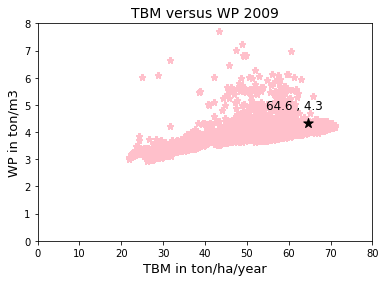

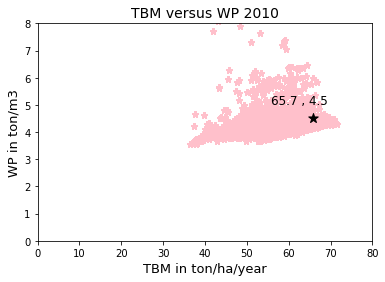

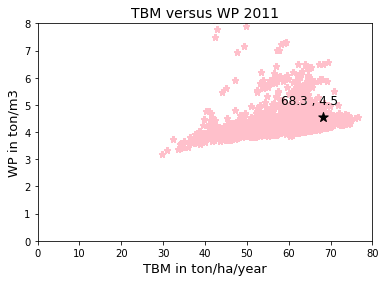

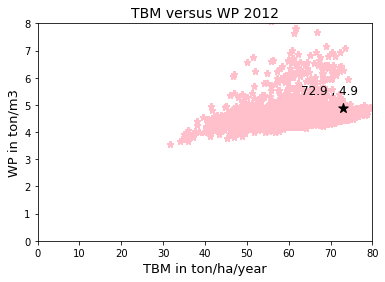

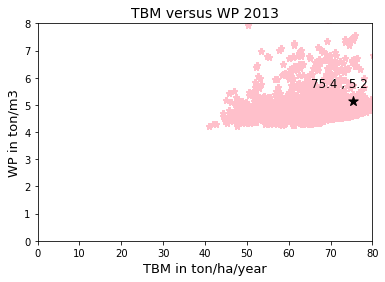

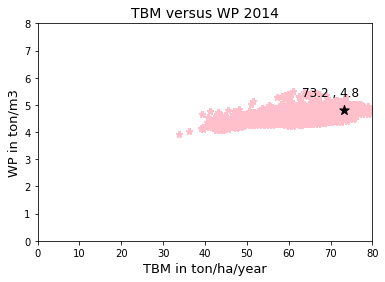

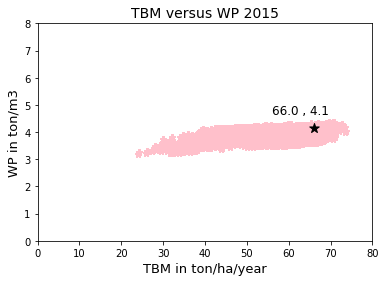

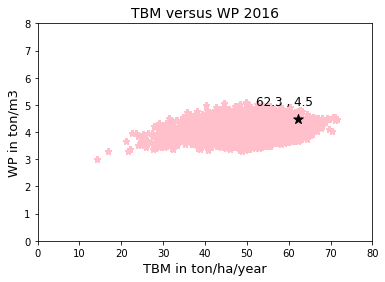

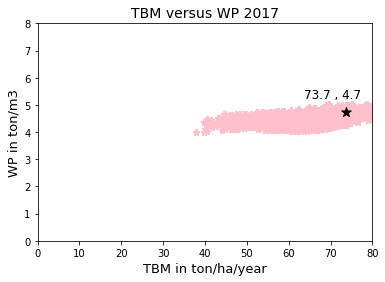

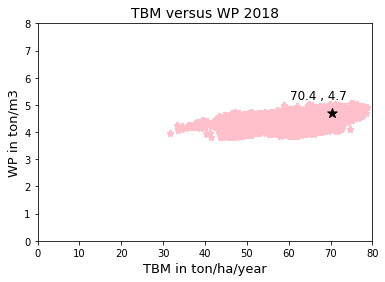

TBM and WP at 95% precentile
2009 64.6 , 4.3
2010 65.7 , 4.5
2011 68.3 , 4.5
2012 72.9 , 4.9
2013 75.4 , 5.2
2014 73.2 , 4.8
2015 66.0 , 4.1
2016 62.3 , 4.5
2017 73.7 , 4.7
2018 70.4 , 4.7
Mean 95%TBM and 95%WP
69.3 , 4.6


In [64]:
# Calculate the WP gaps
yearstart=2009
for i in range (len(WPs)):
    for j in range(WPs[i].shape[1]):
        x = TBMs[i][:j]
        y = WPs[i][:j]
        plt.scatter(x, y,  marker='*', color = 'pink', alpha=0.05)
    plt.title('TBM versus WP '+str(yearstart),fontsize=14)
    plt.xlim(0, 80)
    plt.ylim(0, 8)
    plt.xlabel('TBM in ton/ha/year', fontsize=13)
    plt.ylabel('WP in ton/m3', fontsize=13)
    yearstart+=1
    
    plt.scatter(np.nanpercentile(TBMs[i], 95), np.nanpercentile(WPs[i], 95), marker='*', color='black',s=100)
    plt.text(np.nanpercentile(TBMs[i], 95)-10, np.nanpercentile(WPs[i], 95)+0.5, '{:2.1f}'.format(np.nanpercentile(TBMs[i], 95))+' , '+'{:2.1f}'.format(np.nanpercentile(WPs[i], 95)), fontsize=12)
    plt.show()

NinetyfivePerWP  = []
NinetyfivePerTBM = []
print ('TBM and WP at 95% precentile')
yr = 2009
for i in range (len(WPs)):
    WP  = WPs[i]
    TBM = TBMs[i]
    NinetyfivePerWP.append(np.nanpercentile(WP, 95))
    NinetyfivePerTBM.append(np.nanpercentile(TBM, 95))
    print (yr, '{:2.1f} , {:2.1f}'.format(np.nanpercentile(TBM, 95), np.nanpercentile(WP, 95)))
    yr +=1
    
print ('Mean 95%TBM and 95%WP')
print ('{:2.1f} , {:2.1f}'.format(np.mean(NinetyfivePerTBM), np.mean(NinetyfivePerWP)))

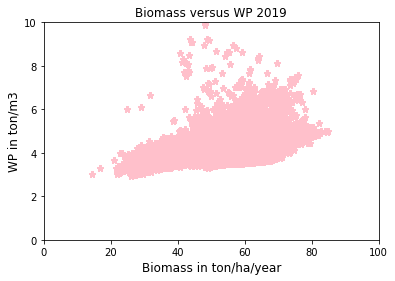

In [65]:
#  Viomass vs WP of all years 
yearstart=2009
for i in range (len(WPs)):
    for j in range(WPs[i].shape[1]):
        x = TBMs[i][:j]
        y = WPs[i][:j]
        plt.scatter(x, y,  marker='*', color = 'pink', alpha=0.05)
    yearstart+=1
plt.title('Biomass versus WP '+str(yearstart))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel('Biomass in ton/ha/year', fontsize=12)
plt.ylabel('WP in ton/m3', fontsize=12)
plt.show()

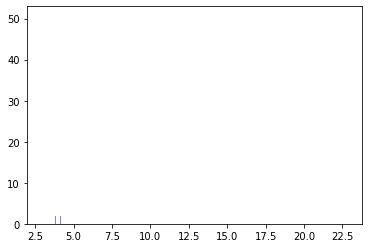

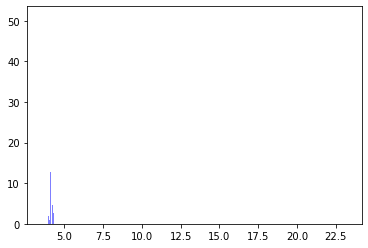

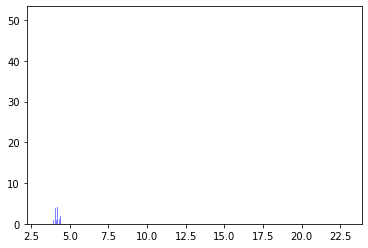

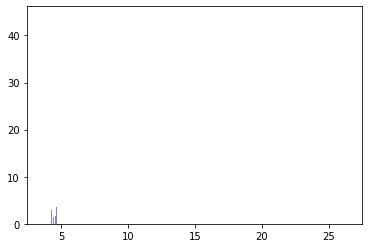

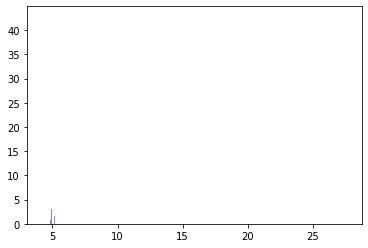

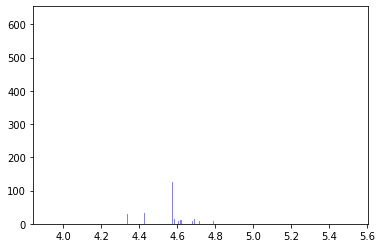

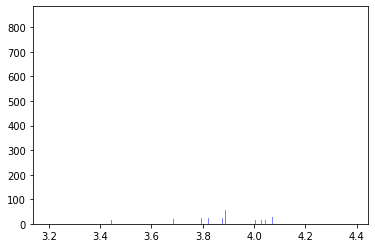

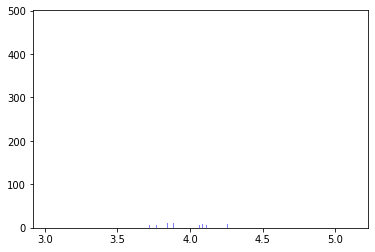

In [ ]:
# Calculate the TBM and WP histogram
import pandas as pd

yearstart=2009
for i in range (len(WPs)):
    for j in range(WPs[i].shape[1]):
        x = TBMs[i][:j]
        y = WPs[i][:j]
    plt.hist(y,1000, density=True, histtype='bar', facecolor='b', alpha=0.5)
    plt.show()
    yearstart+=1   
    



C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


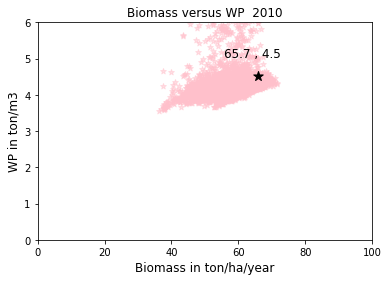

65.7 , 4.5


In [110]:
# Optional for iterating every elements of the arrays! this takes much time
# 2010
WP2  = WPs[1]
TBM2 = TBMs[1]
for i in range(len(WP2)):
    for j in range(len(WP2[i])):
        if WP2[i][j] > 0: 
            x = TBM2[i][j]
            y = WP2[i][j]
            plt.scatter(x, y,  marker='*', color = 'pink', alpha=0.5)
        
plt.title('Biomass versus WP  2010')
plt.xlim(0, 100)
plt.ylim(0, 6)
plt.xlabel('Biomass in ton/ha/year', fontsize=12)
plt.ylabel('WP in ton/m3', fontsize=12)

plt.scatter(np.nanpercentile(TBM2, 95), np.nanpercentile(WP2, 95), marker='*', color='black',s=100)
plt.text(np.nanpercentile(TBM2, 95)-10, np.nanpercentile(WP2, 95)+0.5, '{:2.1f}'.format(np.nanpercentile(TBM2, 95))+' , '+'{:2.1f}'.format(np.nanpercentile(WP2, 95)), fontsize=12)
plt.show()
print ('{:2.1f} , {:2.1f}'.format(np.nanpercentile(TBM2, 95), np.nanpercentile(WP2, 95)))


## Exercise (5b) 
i) Calculate the WP at harvest for your project area 

ii) Plot:
Plot: timeseries of average WP and LP
Plot: ET versus biomass
Plot: biomass versus WP